In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import matplotlib.pyplot as plt
from gurobipy import *
from math import sqrt

In [2]:
# Load in return data files
org_returns = pd.read_csv('org_returns.csv', index_col = 0)

In [3]:
# Split returns data into training, validation and test sets
org_train, org_validate, org_test = np.split(org_returns,
                                             [int(.6*len(org_returns)), int(.8*len(org_returns))])

In [4]:
# Clean nan values from data, drop index column and extract all relevant stocksymbols
org_trainval_noindex = pd.concat([org_train, org_validate], axis = 0).drop('index', axis = 1).dropna(axis = 1, how = 'any')
stocklist = org_trainval_noindex.columns

# Calculate expected returns vector and covariance matrix
stock_return = org_trainval_noindex.mean()
return_cov = org_trainval_noindex.cov()

In [5]:
# Initalise return and std lists to use for plotting
return_list = []
std_list = []

# Get the desired range of standard deviations to use as maximum risk limit
interval = np.arange(0.009, 0.0401, 0.0005)

prev_return = 0
for std in tqdm_notebook(interval):
    time.sleep(0.25)
        
    # Create model
    m = Model()
    # Add weight variable for every stock
    weight_vars = pd.Series(m.addVars(stocklist), index = stocklist)

    # Calculate the portfolio varance and expected return based on the values of weight variables
    portfolio_variance = return_cov.dot(weight_vars).dot(weight_vars)
    portfolio_return = stock_return.dot(weight_vars)

    # Set the objective function to maximise stock returns
    m.setObjective(quicksum(stock_return[stock] * weight_vars[stock] for stock in stocklist), GRB.MAXIMIZE)

    # Limit the porfolio variance at the squared maximum standard deviation
    m.addConstr(portfolio_variance <= std * std)
    # Make sure that entire budget is used to invest in portfolio
    m.addConstr(weight_vars.sum() == 1, 'budget')

    m.setParam('OutputFlag', 0)
    m.update()
    m.optimize()
    
    # Add portfolio returns and current standard deviation into seperate lists
    current_return = portfolio_return.getValue()
    return_list.append(current_return)
    std_list.append(std)
    
    # Stop if the return does not change significantly
    if current_return - prev_return < 0.0000001:
        break
    else:
        prev_return = current_return

Academic license - for non-commercial use only


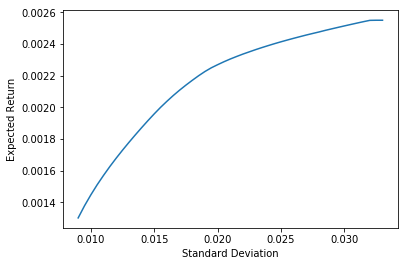

In [6]:
# Plot the efficient frontier for the training and validation set
plt.plot(std_list, return_list) 
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.show()

This graph was used to determine the maximum standard deviation to use in the portfolio optimisation. The chosen value is 0.017 since it is the approximate value where the curve starts flattening out. In other words where the gain in expected returns does not increase as much with increased risk.